# Обучение на MNIST с помощью PyTorch

### Автор: студент группы BD-21 проекта Техносфера Ракитин Виталий.

## Задание:
    
Повторить обучение на mnist из прошлой домашки:
 	
Используя структуру сети Sequental в pytorch реализовать и обучить классификатор цифр из MNIST

1. Количество слоев от 1 до 4
2. Разные размеры скрытых слоев: 5, 10, 50, 100, 300
3. С разными функциями активации (без, ReLU, sigmoid, tanh)
4. С разными функциями потерь (CrossEntropy, MSE, NLL)
5. Со смещениями и без.

Каждый пункт 2-3 варианта.

Результат в форме отчета: скорость и качество обучения от параметров сети.
Везде где имеет смысл нарисовать графики.



### 0. Загрузим MNIST

In [1]:
from sklearn.datasets import fetch_mldata
import sklearn.cross_validation as cv
import numpy as np
import torch
from torch.autograd import Variable
from sklearn.metrics import classification_report

import matplotlib.pyplot as pl
from timeit import default_timer as timer  

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
mnist = fetch_mldata('MNIST original')
train_data, test_data, train_target, test_target =\
            cv.train_test_split(mnist.data, mnist.target, test_size=0.30, random_state=42)
    
nn = torch.nn

In [21]:
def create_y(y):
    new_y = np.zeros((y.shape[0], 10))
    for i in xrange(y.shape[0]):
        new_y[i][int(y[i])] = 1
    return new_y

    
def create_var( train_data, 
                test_data, 
                train_target, 
                test_target
               ):
    test_target_new = create_y(test_target)
    train_target_new = create_y(train_target)
    X_train = Variable(torch.from_numpy(train_data).type(torch.FloatTensor), requires_grad=False)
    Y_train = Variable(torch.from_numpy(train_target).type(torch.LongTensor), requires_grad=False)
    X_test = Variable(torch.from_numpy(test_data).type(torch.FloatTensor), requires_grad=False)
    Y_test = Variable(torch.from_numpy(test_target).type(torch.LongTensor), requires_grad=False)

    return X_train, Y_train, Y_train_wide, X_test, Y_test, Y_test_wide

In [22]:
x_tr,y_tr,y_tr_w,x_tt,y_tt,y_tt_w = create_var(train_data, test_data, train_target, test_target)

## 1. Система для обучения и тестирования 

In [23]:
class NeuNet():
    def __init__(self, 
                 layers,
                 loss_func,
                 layers_num,
                 optimizer = torch.optim.Adam,
                 opt_learning_rate = 1e-5,
                 min_loss_dist = 1e-20,
                ):
        '''
        >>> layers --- list of dicts: {"name" : ModuleName, "module" : Module}
        >>> Loss --- loss function
        '''
        self.layers_num = layers_num
        self.loss_func = loss_func
        self.model = nn.Sequential()
        for layer in layers:
            self.model.add_module(layer["name"], layer["module"])
            
        self.optimizer = optimizer(self.model.parameters(), lr = opt_learning_rate)
        self.min_loss_dist = min_loss_dist
        self.losses = []
        self.loss_diff = []
        self.grad = []
    
    def timer(func):
        def wrapper(*args, **kwargs):
            start = timer()
            result = func(*args, **kwargs)
            end = timer()
            print("Calculation time: {} sec.".format(end - start))
            return result
        return wrapper
    
    @timer    
    def train(self,
              data, 
              target, 
              max_iter_item = 50, 
              batch_size = 40):
        ''' 
        >>> train until the loss function stabilizes 
        '''
        counter = 0
        loss_pred = 1000 * self.min_loss_dist
        loss_diff = 1000 * self.min_loss_dist
        batches_number = len(data) / batch_size

        data_batch = [data[i * batch_size : (i+1) * batch_size] for i in xrange(batches_number)]
        target_batch = [target[i * batch_size : (i+1) * batch_size] for i in xrange(batches_number)]
        
        while  counter < max_iter_item and abs(loss_diff) > self.min_loss_dist:
            
            for i,X in enumerate(data_batch):
                Y = target_batch[i]
                target_pred = self.model(X)
                loss = self.loss_func(target_pred, Y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                         
            target_pred = self.model(data)
            loss = self.loss_func(target_pred, target)
            loss_diff = loss_pred - loss.data[0] 
            loss_pred = loss.data[0]
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.loss_diff.append(loss_diff)
            self.losses.append(loss.data[0])
            
            grad = []
            for child in self.model.children():
                child_grad = []
                for param in child.parameters():
                    child_grad.append(param.grad.data.norm())
                grad.append(child_grad)
            self.grad.append(grad)
            
            counter += 1   


                
    def test(self, data, target, title = None):
        print "________________________________________"
        target_pred = self.model.forward(data)
        res, ind = torch.max(self.model.forward(data),1)
        self.sk_report(ind, target, title)
        distance = (ind - target).data.numpy()
        k = np.array([1 if abs(res.sum()) < 0.5 else 0 for res in distance])
        print "{0} of {1} items identified correctly on {2}.".format(sum(k),len(k), title)
        print "________________________________________"
        
    
    def plot(self,
             x, y,
             title = "Plot",
             xlabel = None,
             ylabel = None,
             axis  = None,
             grid  = True,
             save = False,
             name  = "plot.png",
            ):
        pl.plot(x,y)
        pl.ylabel(ylabel)
        pl.xlabel(xlabel)
        pl.title(title)   
        pl.grid(grid)
        if axis:
            pl.axis(axis)      
        if save:
            pl.savefig(name)
        pl.show()
        pl.close()
        return self
    
    def losses_plot(self):
        steps = [i for i in xrange(len(self.losses))]
        self.plot(steps, self.losses, title = "Losses", xlabel = "steps", ylabel = "Losses on steps")
        self.plot(steps, self.loss_diff, title = "Losses difference", xlabel = "steps", ylabel = "Losses difference")
        
    def grad_plot(self):
        steps = [i for i in xrange(len(self.grad))]
        w = [[] for i in xrange(self.layers_num)]
        b = [[] for i in xrange(self.layers_num)]
        for step in self.grad:
            counter = 0
            for layer in step:
                if len(layer) != 0: # если = 0, значит это функция активации 
                    w[counter].append(layer[0])
                    if len(layer) > 1:
                        b[counter].append(layer[1])
                    counter += 1
                    
        for i in xrange(self.layers_num):
            self.plot(steps, w[i], title = "Weight gradient on {0} layer".format(i+1), xlabel = "steps", ylabel = "Gradients")
            if len(b[i]) != 0:
                self.plot(steps, b[i], title = "Bais gradient on {0} layer".format(i+1), xlabel = "steps", ylabel = "Gradients")
    
    def sk_report(self, ind, target, title = None):
        if title:
            print "Sklearn classification report of " + title
        else:
            print "Sklearn classification report"
        
        print classification_report(np.array(target.data.tolist()), np.array(ind.data.tolist()))
    
    def report(self, data_train, target_train, data_test, target_test):
        self.test(data_train, target_train, "train sample")
        self.test(data_test, target_test, "test sample")
        self.losses_plot()
        self.grad_plot()

# 3. Протестируем различные модели

## Однослойная модель без функции активации

Calculation time: 55.4829189777 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.94      0.99      0.96      4890
          1       0.97      0.97      0.97      5557
          2       0.94      0.87      0.90      4850
          3       0.91      0.89      0.90      5043
          4       0.89      0.95      0.92      4777
          5       0.92      0.82      0.87      4342
          6       0.96      0.96      0.96      4784
          7       0.91      0.94      0.93      5087
          8       0.78      0.90      0.84      4773
          9       0.91      0.82      0.87      4897

avg / total       0.91      0.91      0.91     49000

44691 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

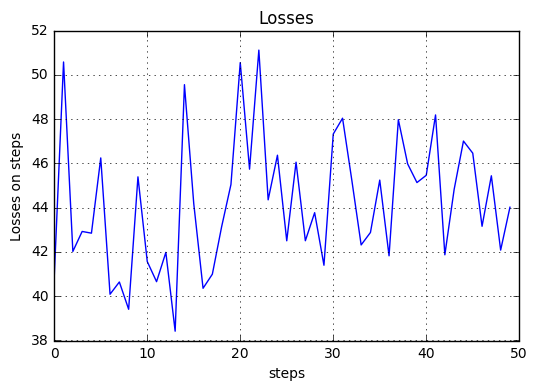

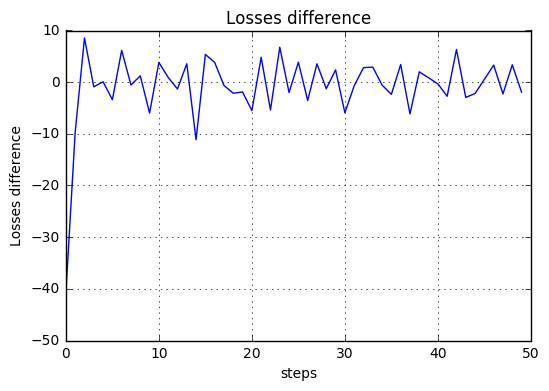

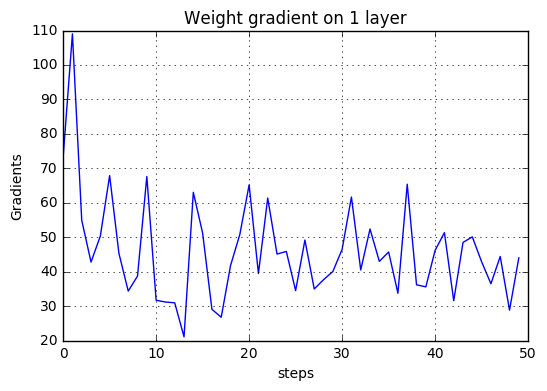

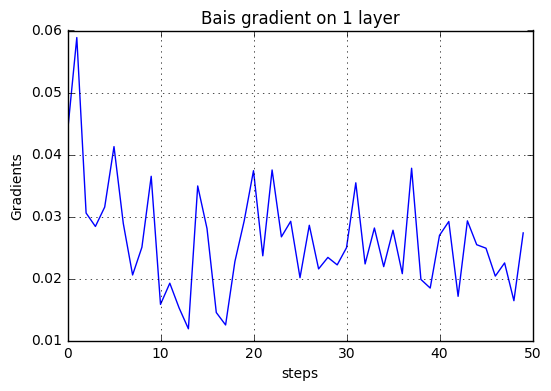

In [24]:
D_in_1 = int(x_tr.size()[1])
D_out_1 = 10
layer_1 = [{"name":"Linear1", "module": nn.Linear(D_in_1, D_out_1)}]

loss_func_1 = nn.CrossEntropyLoss(size_average=True)
layers_num_1 = 1
model_1 = NeuNet(layer_1, loss_func = loss_func_1, layers_num = layers_num_1, opt_learning_rate = 1e-2)
model_1.train(x_tr, y_tr, batch_size = 30, max_iter_item = 50)
model_1.report(x_tr, y_tr, x_tt, y_tt)

Уменьшим learning rate.

Calculation time: 49.9520699978 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.97      0.97      0.97      4890
          1       0.98      0.97      0.97      5557
          2       0.90      0.91      0.90      4850
          3       0.91      0.88      0.90      5043
          4       0.93      0.94      0.93      4777
          5       0.84      0.90      0.87      4342
          6       0.95      0.95      0.95      4784
          7       0.97      0.87      0.92      5087
          8       0.87      0.83      0.85      4773
          9       0.84      0.92      0.88      4897

avg / total       0.92      0.92      0.92     49000

44860 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

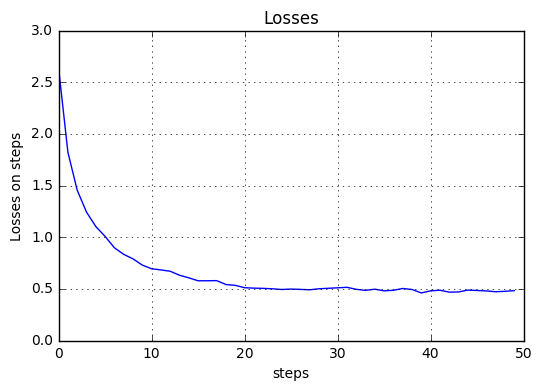

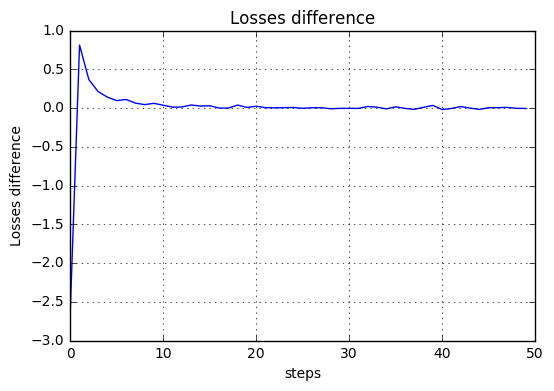

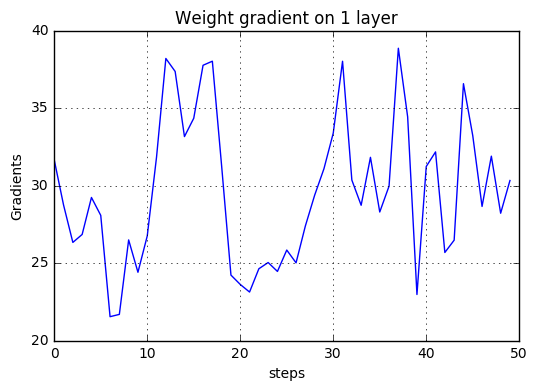

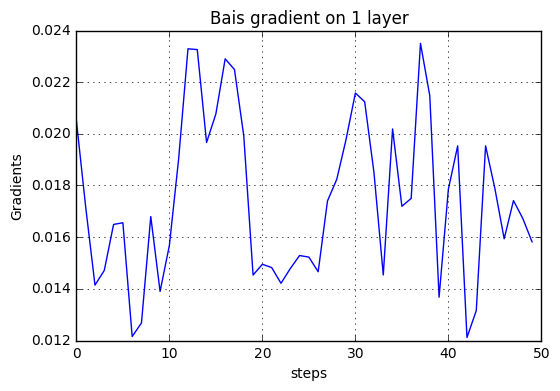

In [45]:
D_in_1 = int(x_tr.size()[1])
D_out_1 = 10
layer_1 = [{"name":"Linear1", "module": nn.Linear(D_in_1, D_out_1)}]

loss_func_1 = nn.CrossEntropyLoss(size_average=True)
layers_num_1 = 1
model_1 = NeuNet(layer_1, loss_func = loss_func_1, layers_num = layers_num_1, opt_learning_rate = 1e-4)
model_1.train(x_tr, y_tr, batch_size = 30, max_iter_item = 50)
model_1.report(x_tr, y_tr, x_tt, y_tt)

Видно, что значение функции потерь постепенно выходит на константу. Даже на такой простой модели результаты получились неплохие.

А что будет если убрать смещение (bais) из данной модели?

## Однослойная модель без смещения

Calculation time: 34.4566948414 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.95      0.98      0.97      4890
          1       0.98      0.97      0.97      5557
          2       0.90      0.91      0.91      4850
          3       0.91      0.88      0.90      5043
          4       0.91      0.95      0.93      4777
          5       0.84      0.89      0.86      4342
          6       0.93      0.97      0.95      4784
          7       0.94      0.89      0.92      5087
          8       0.87      0.84      0.86      4773
          9       0.90      0.86      0.88      4897

avg / total       0.92      0.92      0.91     49000

44837 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

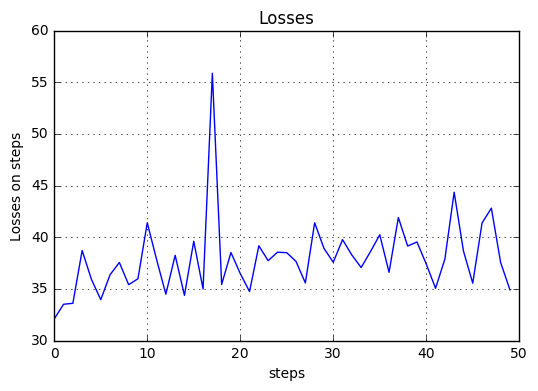

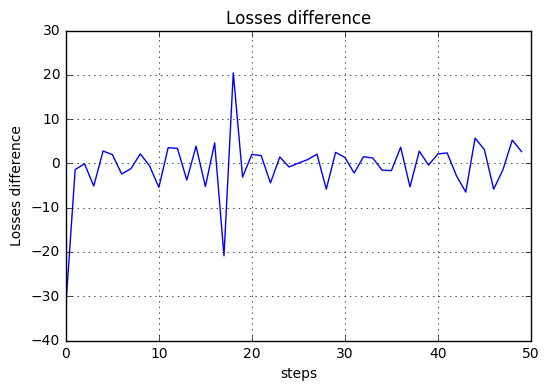

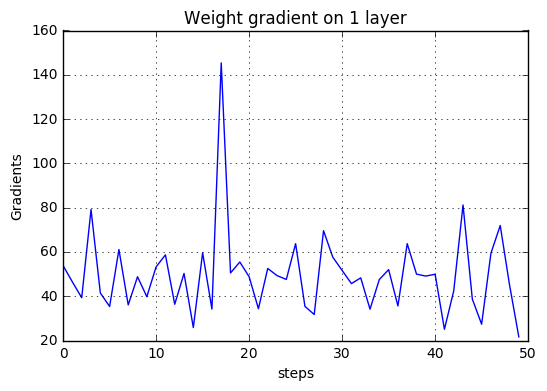

In [25]:
D_in_2 = int(x_tr.size()[1])
D_out_2 = 10
layer_2 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_out_1, bias = False)}]
        
loss_func_2 = nn.CrossEntropyLoss(size_average=True)
layers_num_2 = 1
model_2 = NeuNet(layer_2, loss_func = loss_func_2, layers_num = layers_num_2, opt_learning_rate = 1e-2)

model_2.train(x_tr, y_tr)
model_2.report(x_tr, y_tr, x_tt, y_tt)

Результаты получились не хуже. Однако, заметно уменьшилась скорость обучения.

Попробуем добавить функцию активации.

## Однослойная модель с функцией активации - сигмоидой.

Calculation time: 54.7839930058 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.19      0.95      0.31      4890
          1       0.00      0.00      0.00      5557
          2       0.87      0.86      0.86      4850
          3       0.00      0.00      0.00      5043
          4       0.65      0.96      0.77      4777
          5       0.00      0.00      0.00      4342
          6       0.00      0.00      0.00      4784
          7       0.82      0.90      0.85      5087
          8       0.56      0.75      0.64      4773
          9       0.00      0.00      0.00      4897

avg / total       0.31      0.44      0.34     49000

21516 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

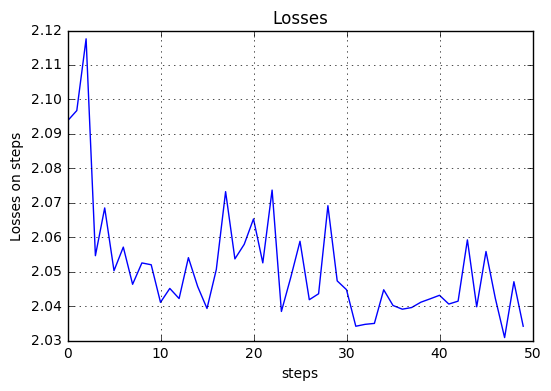

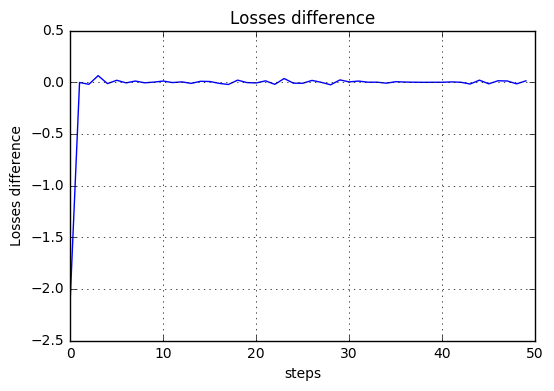

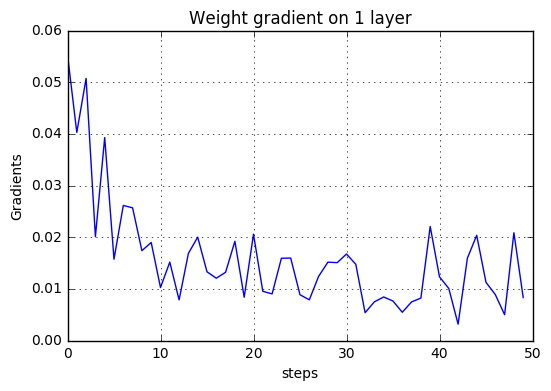

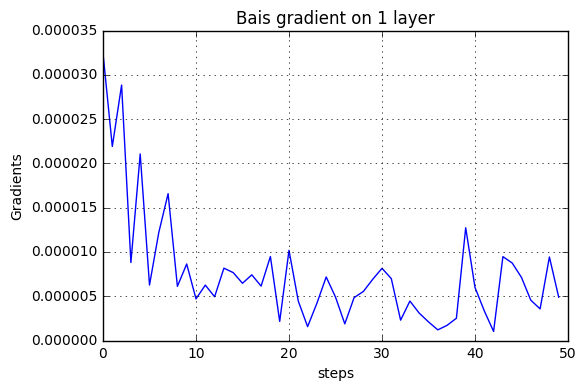

In [26]:
D_in_3 = int(x_tr.size()[1])
D_out_3 = 10
layer_3 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_out_1)},
           {"name": "sigmoid", "module": nn.Sigmoid()}]
        
loss_func_3 = nn.CrossEntropyLoss(size_average=True)
layers_num_3 = 1
model_3 = NeuNet(layer_3, loss_func = loss_func_3, layers_num = layers_num_3, opt_learning_rate = 1e-2)

model_3.train(x_tr, y_tr)
model_3.report(x_tr, y_tr, x_tt, y_tt)

Calculation time: 53.9410660267 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.91      0.99      0.95      4890
          1       0.95      0.98      0.97      5557
          2       0.86      0.93      0.89      4850
          3       0.85      0.88      0.87      5043
          4       0.86      0.96      0.91      4777
          5       0.86      0.80      0.83      4342
          6       0.96      0.92      0.94      4784
          7       0.95      0.90      0.93      5087
          8       0.91      0.84      0.87      4773
          9       0.94      0.86      0.90      4897

avg / total       0.91      0.91      0.91     49000

44452 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

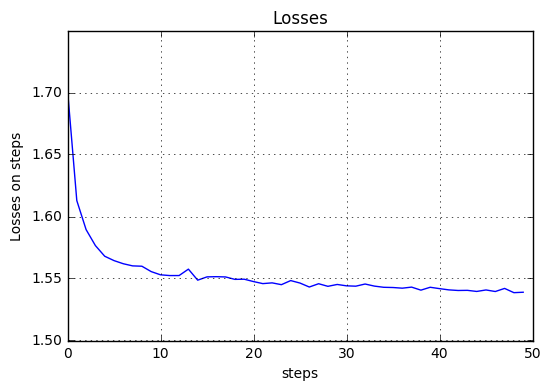

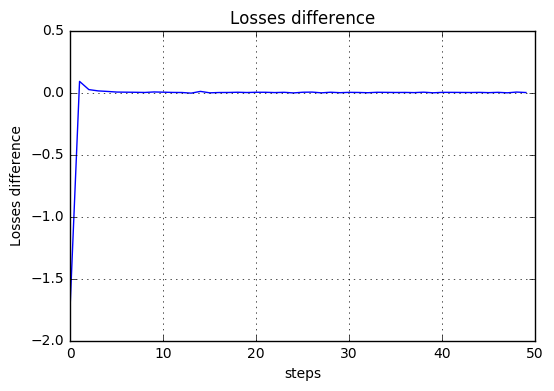

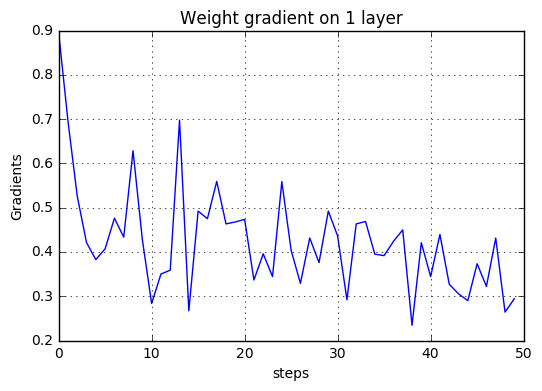

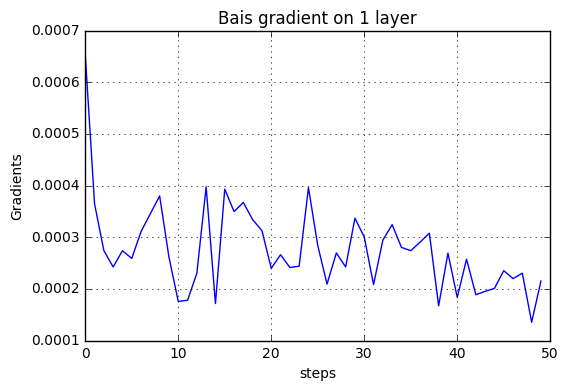

In [53]:
D_in_3 = int(x_tr.size()[1])
D_out_3 = 10
layer_3 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_out_1)},
           {"name": "sigmoid", "module": nn.Sigmoid()}]
        
loss_func_3 = nn.CrossEntropyLoss(size_average=True)
layers_num_3 = 1
model_3 = NeuNet(layer_3, loss_func = loss_func_3, layers_num = layers_num_3, opt_learning_rate = 1e-4)

model_3.train(x_tr, y_tr)
model_3.report(x_tr, y_tr, x_tt, y_tt)

Результаты получились немного хуже, чем без функции активации, но ухудшение незначительно (1-2%).

## Однослойная модель с функциями активации - Relu, LogSoftMax

Calculation time: 56.8598809242 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.21      1.00      0.34      4890
          1       0.99      0.95      0.97      5557
          2       0.98      0.85      0.91      4850
          3       0.98      0.81      0.89      5043
          4       0.00      0.00      0.00      4777
          5       0.97      0.78      0.86      4342
          6       0.00      0.00      0.00      4784
          7       1.00      0.86      0.92      5087
          8       0.00      0.00      0.00      4773
          9       0.95      0.79      0.86      4897

avg / total       0.62      0.61      0.58     49000

29956 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

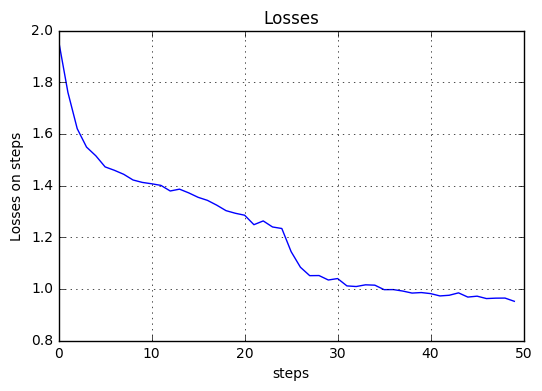

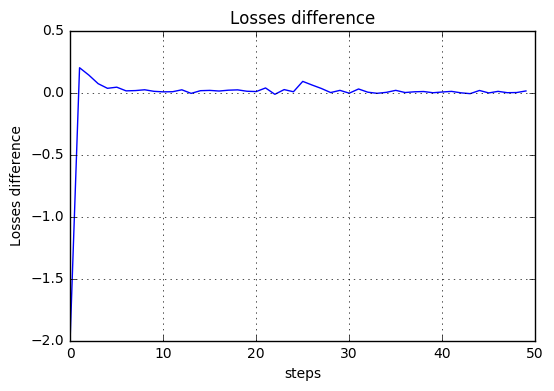

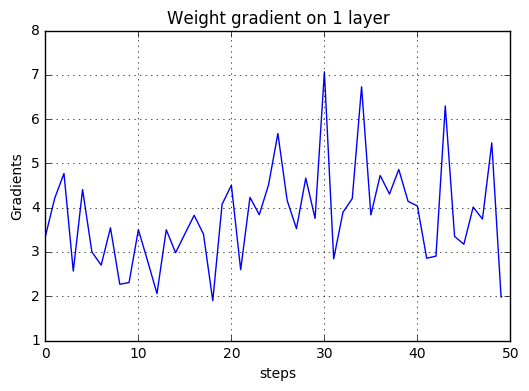

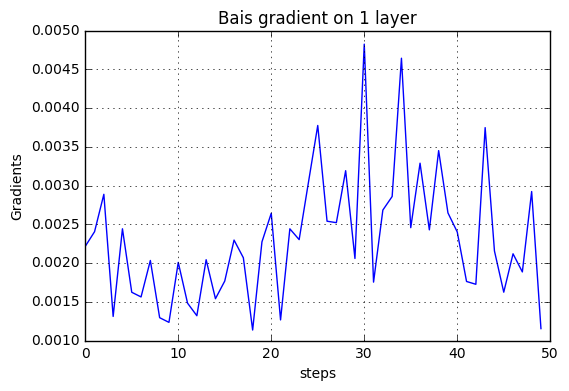

In [46]:
D_in_41 = int(x_tr.size()[1])
D_out_41 = 10
layer_41 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_out_1)},
           {"name": "Relu", "module": nn.ReLU()}]
        
loss_func_41 = nn.CrossEntropyLoss(size_average=True)
layers_num_41 = 1
model_41 = NeuNet(layer_41, loss_func = loss_func_41, layers_num = layers_num_41, opt_learning_rate = 1e-4)

model_41.train(x_tr, y_tr)
model_41.report(x_tr, y_tr, x_tt, y_tt)

Calculation time: 48.6023039818 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.92      0.99      0.95      4890
          1       0.97      0.98      0.97      5557
          2       0.90      0.90      0.90      4850
          3       0.95      0.85      0.89      5043
          4       0.87      0.96      0.91      4777
          5       0.82      0.91      0.86      4342
          6       0.96      0.93      0.94      4784
          7       0.92      0.93      0.93      5087
          8       0.86      0.86      0.86      4773
          9       0.92      0.81      0.86      4897

avg / total       0.91      0.91      0.91     49000

44621 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

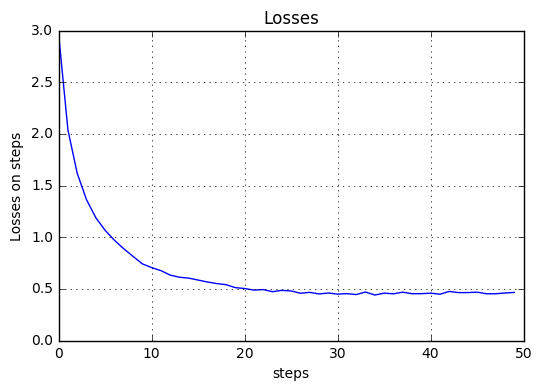

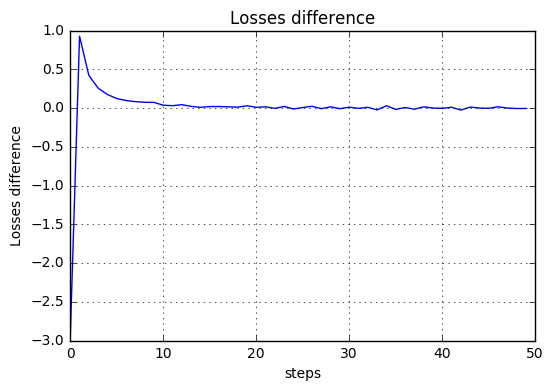

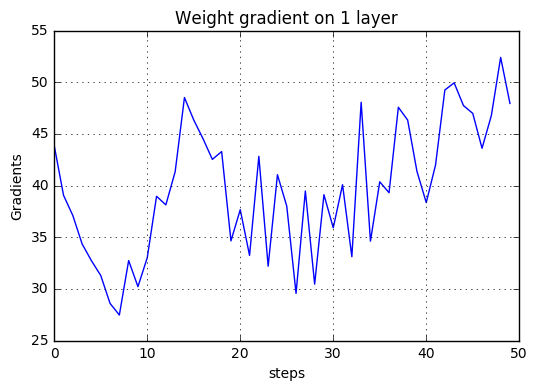

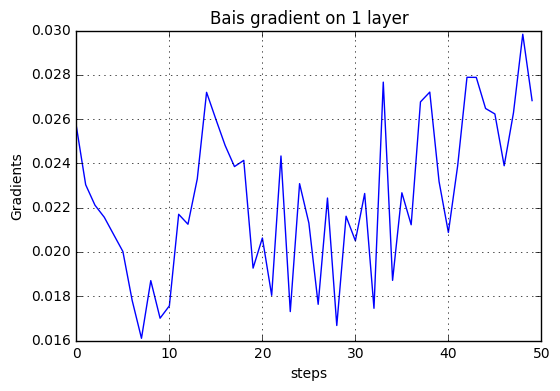

In [47]:
D_in_42 = int(x_tr.size()[1])
D_out_42 = 10
layer_42 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_out_1)},
            {"name":"LSM", "module":torch.nn.LogSoftmax()}]
        
loss_func_42 = nn.CrossEntropyLoss(size_average=True)
layers_num_42 = 1
model_42 = NeuNet(layer_42, loss_func = loss_func_42, layers_num = layers_num_42, opt_learning_rate = 1e-4)

model_42.train(x_tr, y_tr)
model_42.report(x_tr, y_tr, x_tt, y_tt)

Calculation time: 10.8063158989 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.10      1.00      0.18      4890
          1       1.00      0.00      0.00      5557
          2       0.00      0.00      0.00      4850
          3       0.00      0.00      0.00      5043
          4       0.00      0.00      0.00      4777
          5       0.00      0.00      0.00      4342
          6       0.00      0.00      0.00      4784
          7       0.00      0.00      0.00      5087
          8       0.00      0.00      0.00      4773
          9       0.00      0.00      0.00      4897

avg / total       0.12      0.10      0.02     49000

4891 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   support

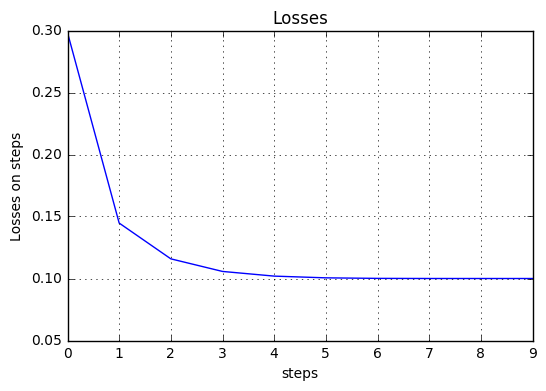

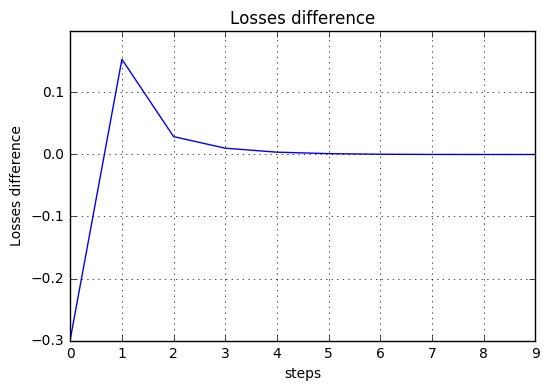

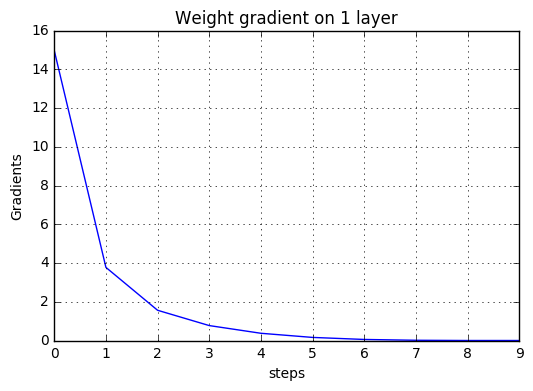

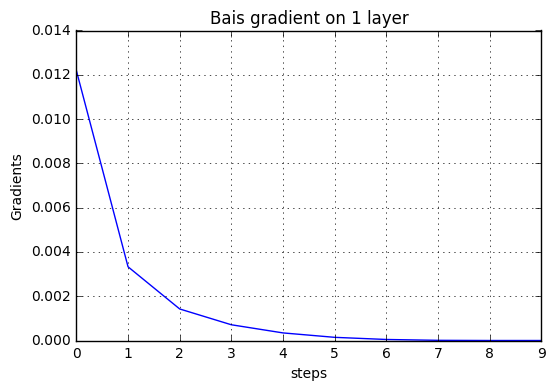

In [48]:
D_in_43 = int(x_tr.size()[1])
D_out_43 = 10
layer_43 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_out_1)},
            {"name":"Relu", "module": nn.ReLU()}]

loss_func_43 = nn.MSELoss(size_average=True)
layers_num_43 = 1
model_43 = NeuNet(layer_43, loss_func = loss_func_43, layers_num = layers_num_43, opt_learning_rate = 1e-4)

model_43.train(x_tr, y_tr_w)
model_43.report(x_tr, y_tr, x_tt, y_tt)

## Однослойная модель с функцией активации - Tanh.

Calculation time: 49.7177360058 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.33      0.99      0.50      4890
          1       0.00      0.00      0.00      5557
          2       0.92      0.90      0.91      4850
          3       0.85      0.87      0.86      5043
          4       0.90      0.94      0.92      4777
          5       1.00      0.00      0.00      4342
          6       0.95      0.93      0.94      4784
          7       0.92      0.92      0.92      5087
          8       0.76      0.82      0.79      4773
          9       0.92      0.83      0.87      4897

avg / total       0.74      0.72      0.67     49000

35215 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

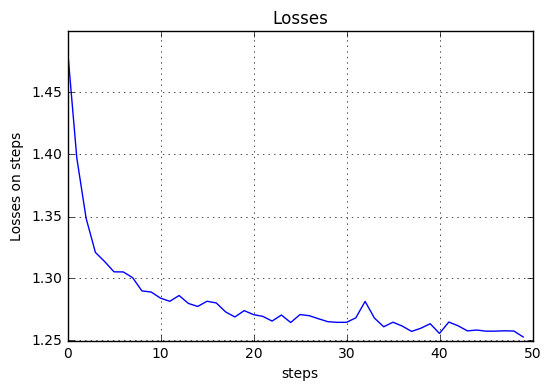

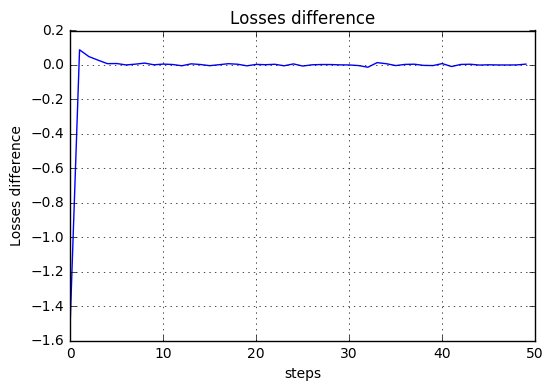

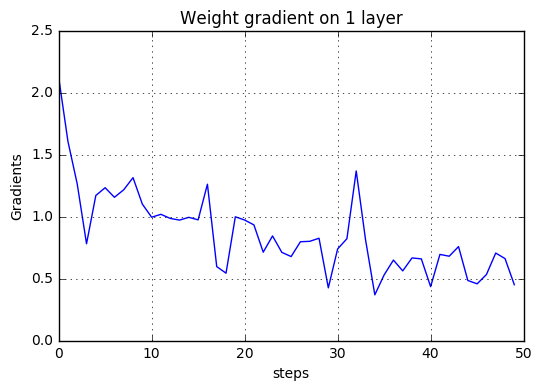

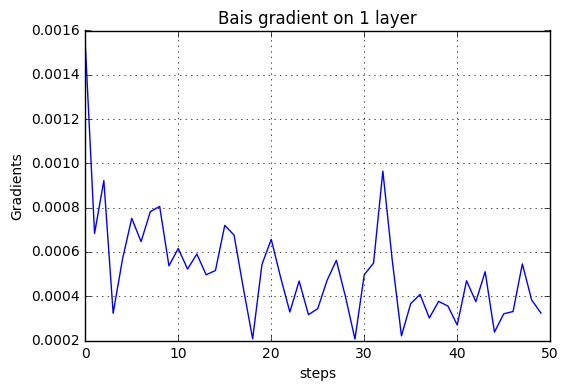

In [49]:
D_in_5 = int(x_tr.size()[1])
D_out_5 = 10
layer_5 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_out_1)},
           {"name": "Tanh", "module": nn.Tanh()}]
 
loss_func_5 =  nn.CrossEntropyLoss(size_average=True)
layers_num_5 = 1
model_5 = NeuNet(layer_5, loss_func = loss_func_5, layers_num = layers_num_5, opt_learning_rate = 1e-4)


model_5.train(x_tr, y_tr)
model_5.report(x_tr, y_tr, x_tt, y_tt)

Интересный факт: наиболее качественная классификация получилась без функции активации классификация.

## Двухслойная модель

Calculation time: 67.0320749283 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.34      0.96      0.50      4890
          1       0.42      0.98      0.59      5557
          2       0.90      0.51      0.65      4850
          3       1.00      0.00      0.00      5043
          4       0.86      0.58      0.69      4777
          5       0.00      0.00      0.00      4342
          6       0.88      0.85      0.87      4784
          7       0.84      0.61      0.71      5087
          8       0.50      0.00      0.00      4773
          9       0.52      0.84      0.64      4897

avg / total       0.63      0.54      0.47     49000

26701 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

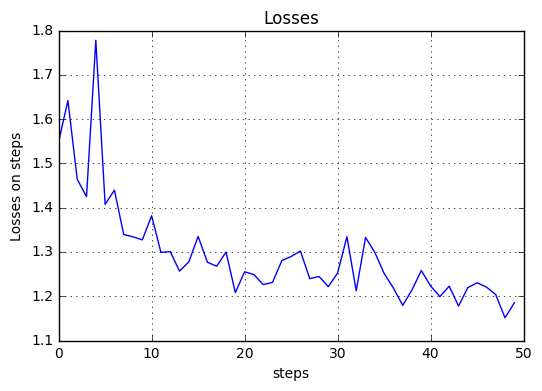

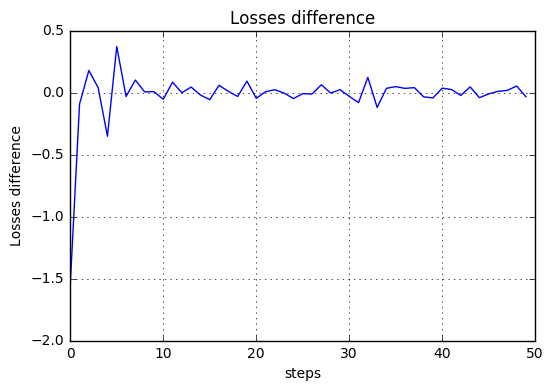

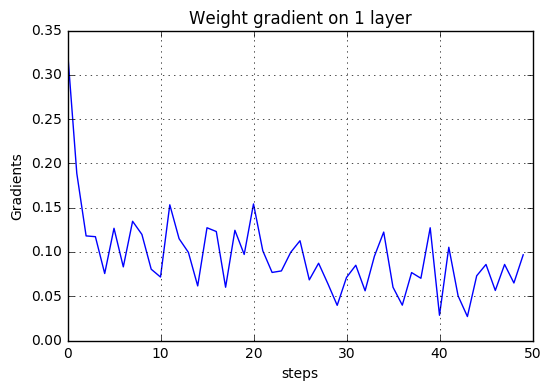

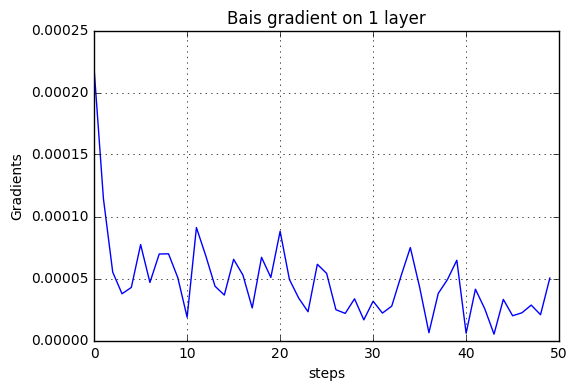

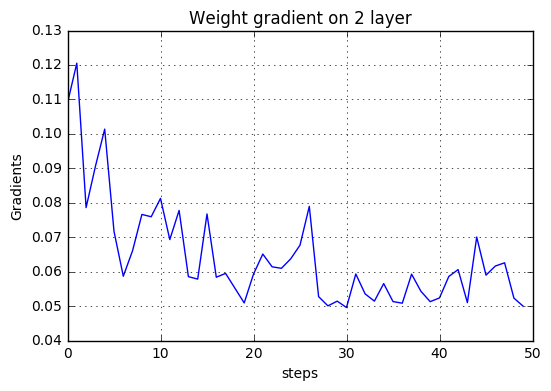

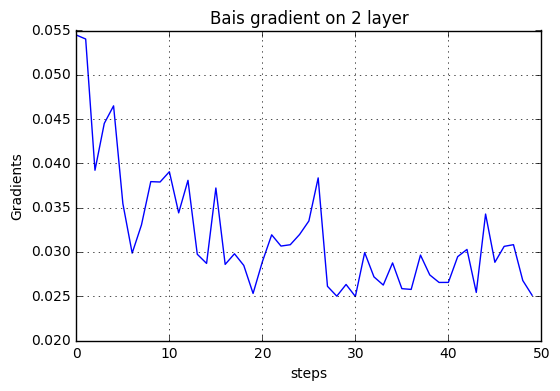

In [32]:
D_in_6 = int(x_tr.size()[1])
D_hidden = 10
D_out_6 = 10
layer_6 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_hidden)},
           {"name": "sigmoid", "module": nn.Sigmoid()},
           {"name":"Linear1", "module": nn.Linear(D_hidden, D_out_1)}]

loss_func_6 =  nn.CrossEntropyLoss(size_average=True)
layers_num_6 = 2
model_6 = NeuNet(layer_6, loss_func = loss_func_6, layers_num = layers_num_6, opt_learning_rate = 1e-2)

model_6.train(x_tr, y_tr)
model_6.report(x_tr, y_tr, x_tt, y_tt)

Calculation time: 178.796116114 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.87      0.94      0.90      4890
          1       0.95      0.93      0.94      5557
          2       0.86      0.85      0.85      4850
          3       0.76      0.81      0.79      5043
          4       0.90      0.84      0.87      4777
          5       0.91      0.65      0.76      4342
          6       0.90      0.92      0.91      4784
          7       0.91      0.89      0.90      5087
          8       0.74      0.83      0.78      4773
          9       0.81      0.87      0.84      4897

avg / total       0.86      0.86      0.86     49000

42009 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

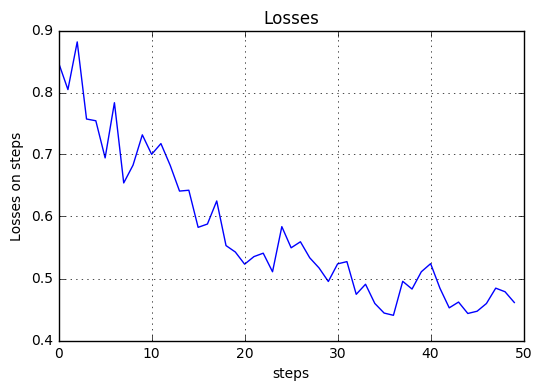

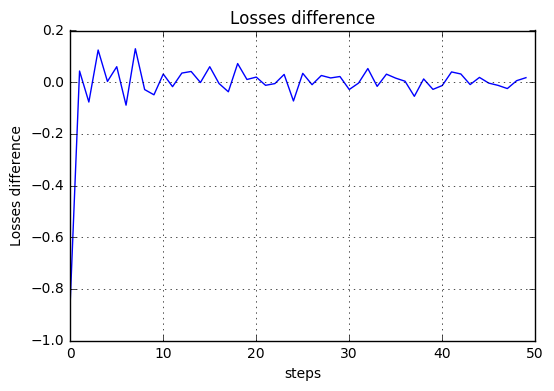

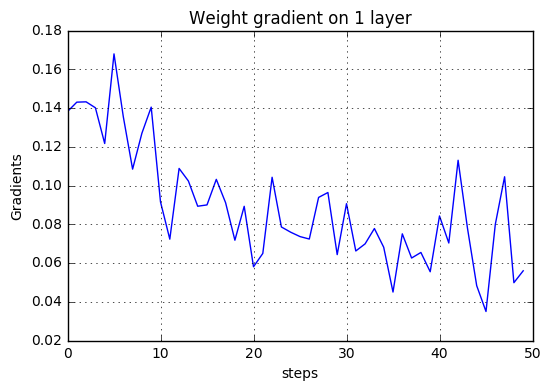

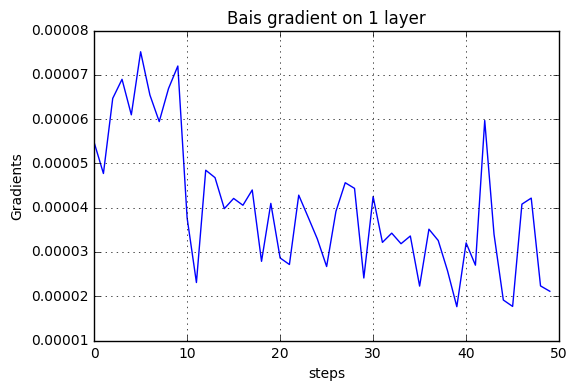

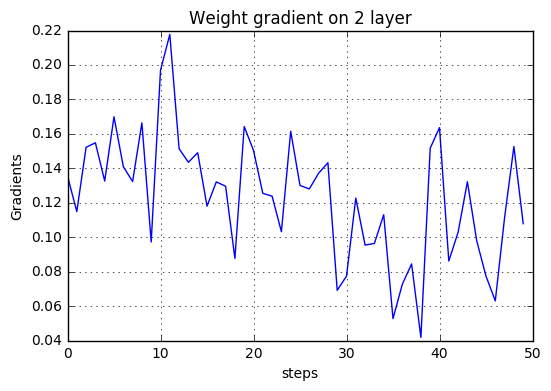

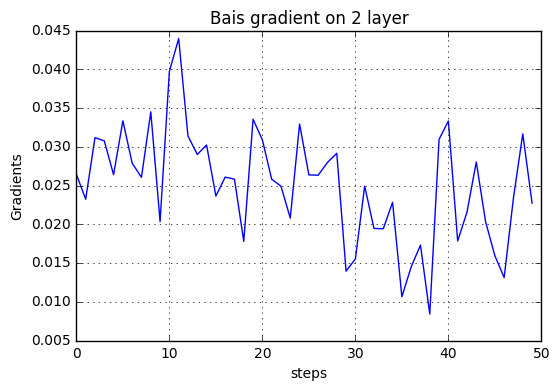

In [33]:
D_in_7 = int(x_tr.size()[1])
D_hidden = 50
D_out_7 = 10
layer_7 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_hidden)},
           {"name": "sigmoid", "module": nn.Sigmoid()},
           {"name":"Linear1", "module": nn.Linear(D_hidden, D_out_1)}]
loss_func_7 =  nn.CrossEntropyLoss(size_average=True)
layers_num_7 = 2
model_7 = NeuNet(layer_7, loss_func = loss_func_7, layers_num = layers_num_7, opt_learning_rate = 1e-2)

        
model_7.train(x_tr, y_tr)
model_7.report(x_tr, y_tr, x_tt, y_tt)

Calculation time: 374.410120964 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.87      0.96      0.91      4890
          1       0.95      0.95      0.95      5557
          2       0.90      0.85      0.87      4850
          3       0.84      0.80      0.82      5043
          4       0.89      0.83      0.86      4777
          5       0.84      0.80      0.82      4342
          6       0.94      0.87      0.90      4784
          7       0.94      0.87      0.90      5087
          8       0.74      0.84      0.79      4773
          9       0.78      0.87      0.82      4897

avg / total       0.87      0.87      0.87     49000

42410 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

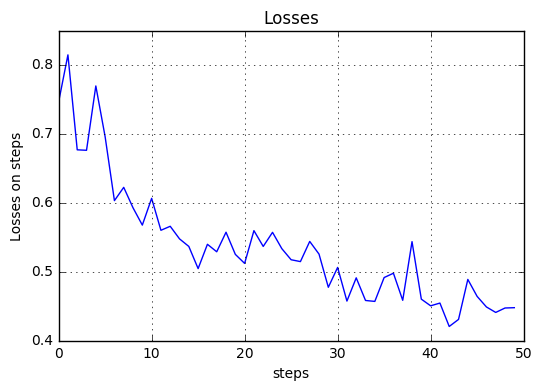

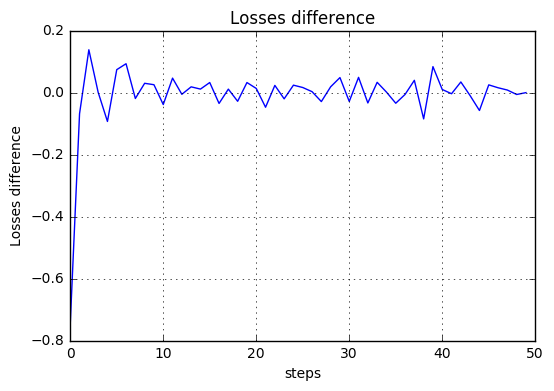

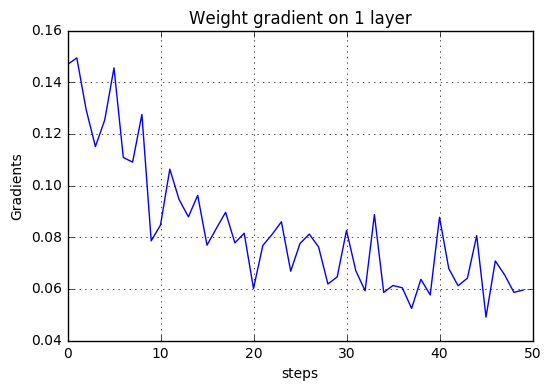

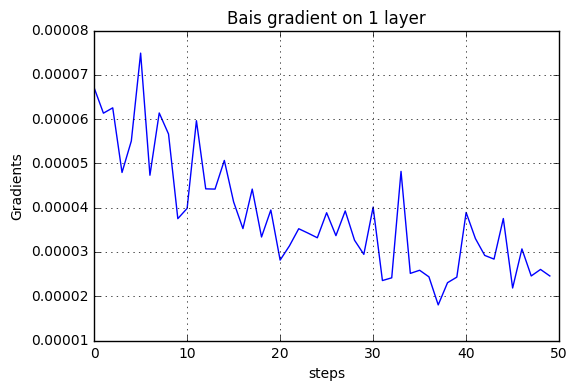

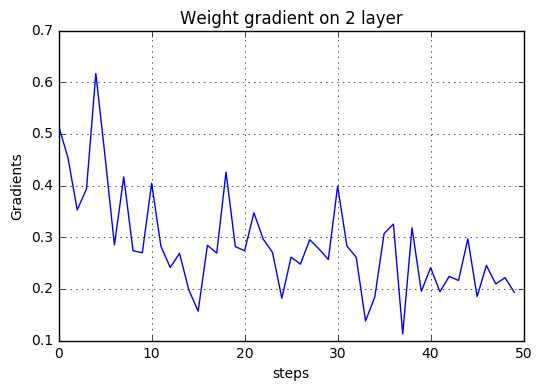

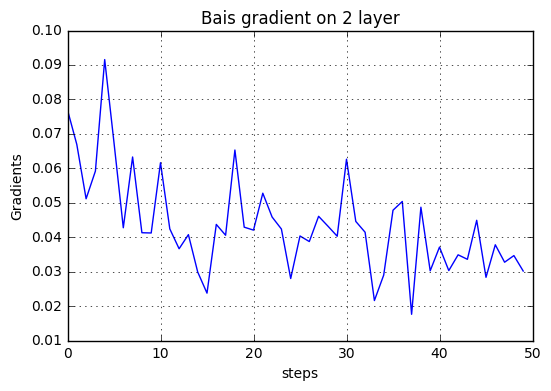

In [34]:
D_in_8 = int(x_tr.size()[1])
D_hidden = 100
D_out_8 = 10
layer_8 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_hidden)},
           {"name": "sigmoid", "module": nn.Sigmoid()},
           {"name":"Linear1", "module": nn.Linear(D_hidden, D_out_1)}]
        
loss_func_8 =  nn.CrossEntropyLoss(size_average=True)
layers_num_8 = 2
model_8 = NeuNet(layer_8, loss_func = loss_func_8, layers_num = layers_num_8, opt_learning_rate = 1e-2)

model_8.train(x_tr, y_tr)
model_8.report(x_tr, y_tr, x_tt, y_tt)

Очевидно, что при увеличении количества параметров, качество обучения - увеличивется. 
А что если уменьшить learning rate?

Calculation time: 246.757727146 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      4890
          1       1.00      0.99      0.99      5557
          2       0.98      0.98      0.98      4850
          3       0.98      0.98      0.98      5043
          4       0.98      0.99      0.98      4777
          5       0.99      0.98      0.99      4342
          6       0.99      0.99      0.99      4784
          7       0.99      0.99      0.99      5087
          8       0.98      0.99      0.98      4773
          9       0.98      0.98      0.98      4897

avg / total       0.99      0.99      0.99     49000

48338 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

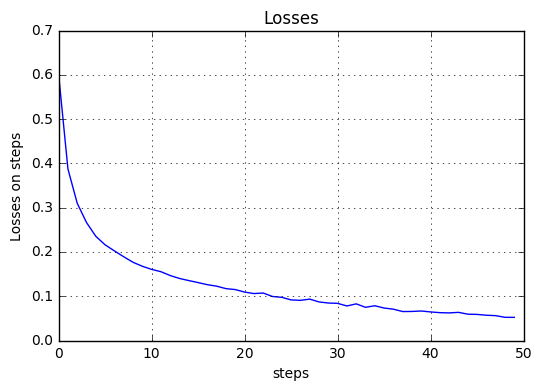

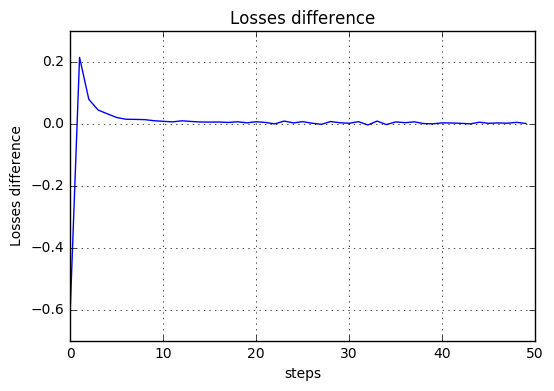

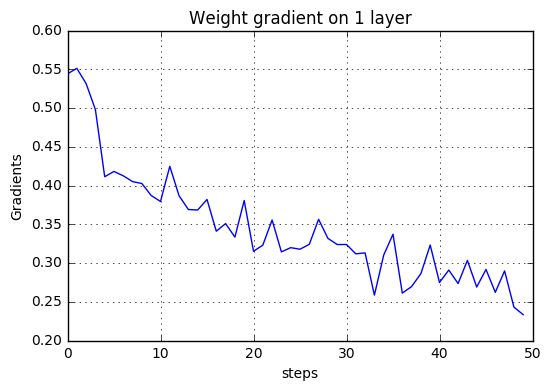

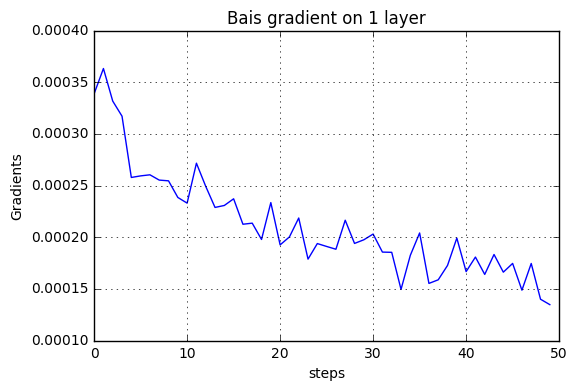

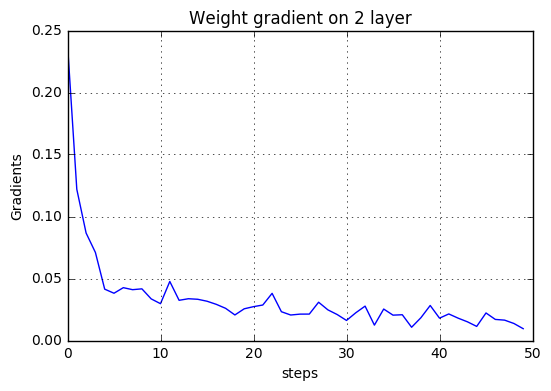

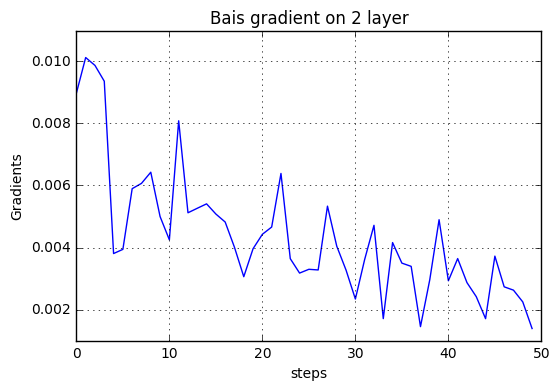

In [44]:
D_in_8 = int(x_tr.size()[1])
D_hidden = 100
D_out_8 = 10
layer_8 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_hidden)},
           {"name": "sigmoid", "module": nn.Sigmoid()},
           {"name":"Linear1", "module": nn.Linear(D_hidden, D_out_1)}]
        
loss_func_8 =  nn.CrossEntropyLoss(size_average=True)
layers_num_8 = 2
model_8 = NeuNet(layer_8, loss_func = loss_func_8, layers_num = layers_num_8, opt_learning_rate = 1e-4)

model_8.train(x_tr, y_tr)
model_8.report(x_tr, y_tr, x_tt, y_tt)

При learning-rate. Заметно, что двуслойные модели работают значительно медленнее однослойных. Однако, качество классификации получается выше, чем в однослойных системах.

## Трёхслойная модель

Calculation time: 420.841665983 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.88      0.95      0.92      4890
          1       0.92      0.96      0.94      5557
          2       0.91      0.75      0.82      4850
          3       0.75      0.84      0.79      5043
          4       0.79      0.82      0.80      4777
          5       0.84      0.71      0.77      4342
          6       0.89      0.90      0.89      4784
          7       0.95      0.86      0.90      5087
          8       0.73      0.81      0.76      4773
          9       0.78      0.78      0.78      4897

avg / total       0.84      0.84      0.84     49000

41133 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

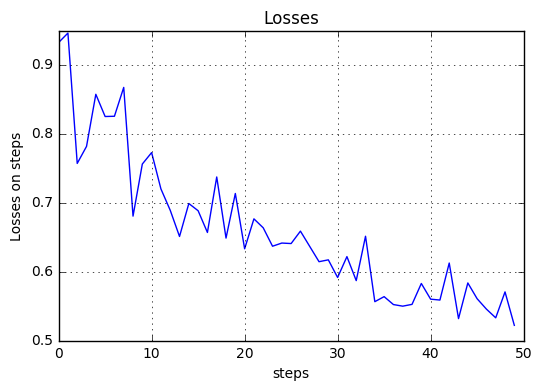

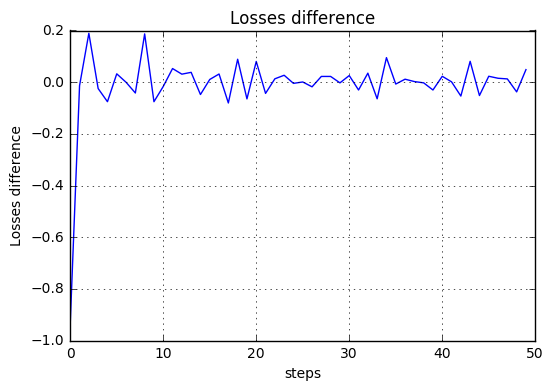

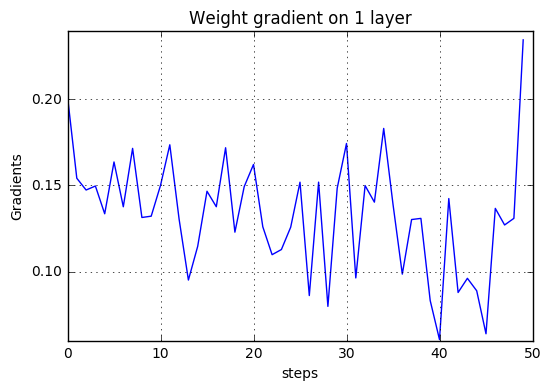

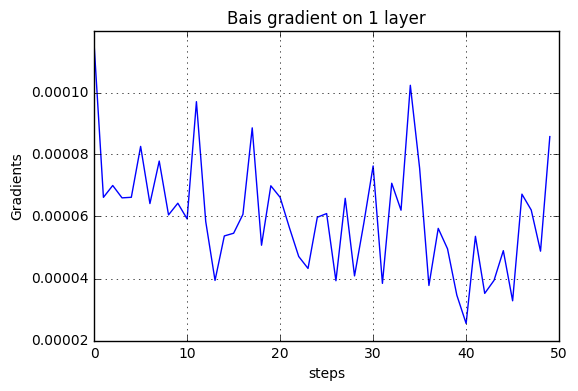

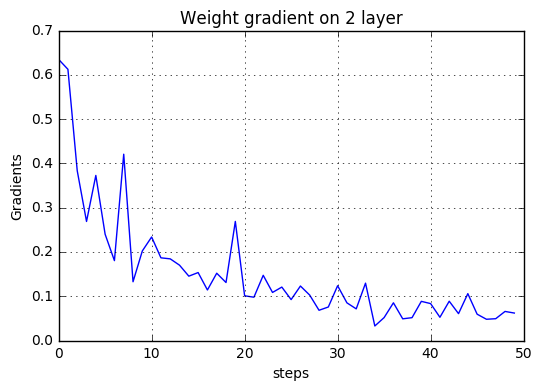

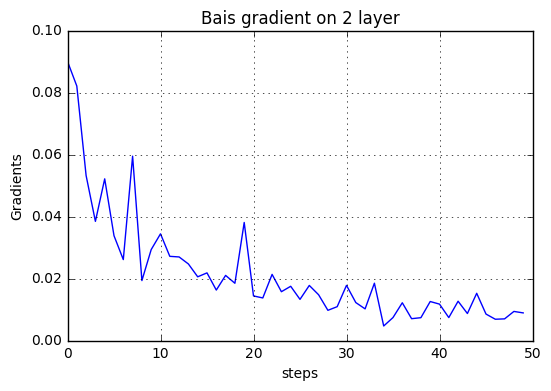

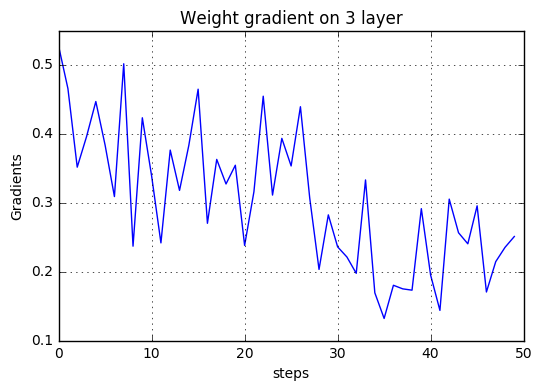

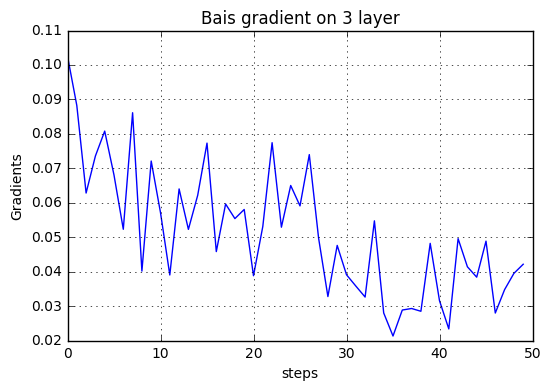

In [40]:
D_in_9 = int(x_tr.size()[1])
D_hidden1 = 100
D_hidden2 = 50
D_out_9 = 10
layer_9 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_hidden1)},
           {"name": "sigmoid", "module": nn.Sigmoid()},
           {"name":"Linear1", "module": nn.Linear(D_hidden1, D_hidden2)},
           {"name": "Tanh", "module": nn.Tanh()},
           {"name":"Linear2", "module": nn.Linear(D_hidden2, D_out_1)}]

loss_func_9 =  nn.CrossEntropyLoss(size_average=True)
layers_num_9 = 3
model_9 = NeuNet(layer_9, loss_func = loss_func_9, layers_num = layers_num_9, opt_learning_rate = 1e-2)

        
model_9.train(x_tr, y_tr)
model_9.report(x_tr, y_tr, x_tt, y_tt)

Уменьшим Learning Rate

Calculation time: 324.888375044 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      4890
          1       0.99      0.99      0.99      5557
          2       0.99      0.99      0.99      4850
          3       0.98      0.98      0.98      5043
          4       0.98      0.99      0.99      4777
          5       0.98      0.99      0.99      4342
          6       0.99      0.99      0.99      4784
          7       0.99      0.99      0.99      5087
          8       0.99      0.98      0.98      4773
          9       0.98      0.98      0.98      4897

avg / total       0.99      0.99      0.99     49000

48423 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

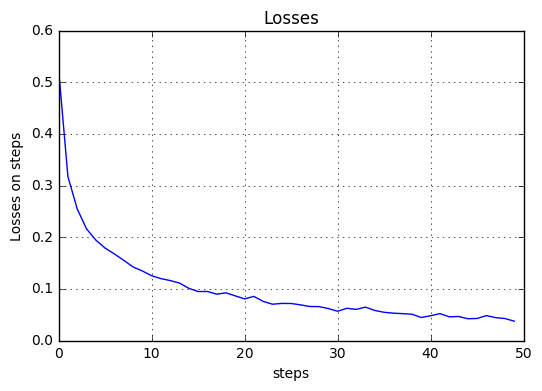

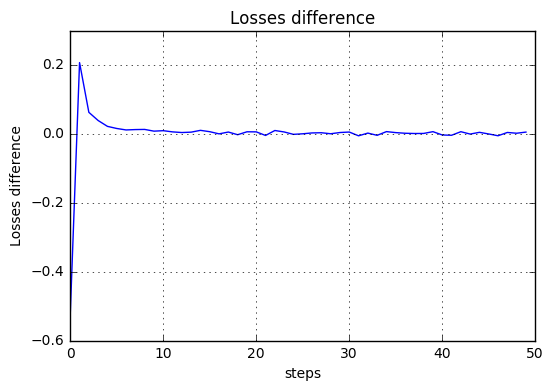

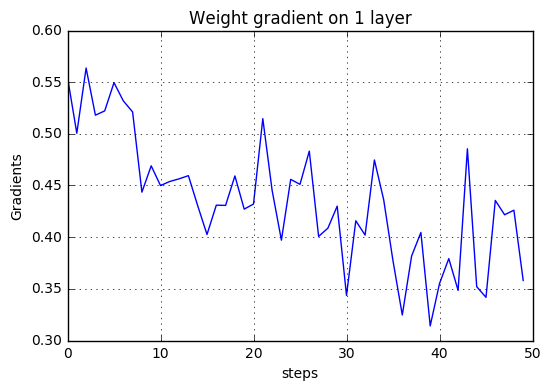

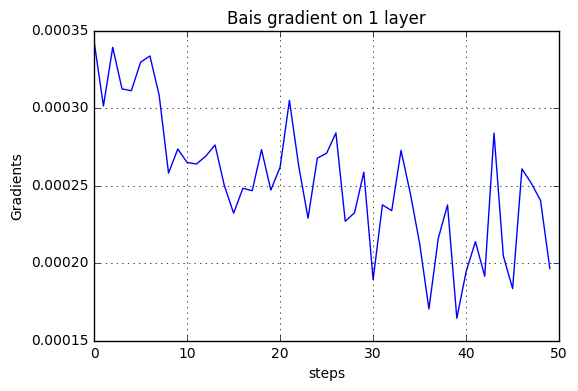

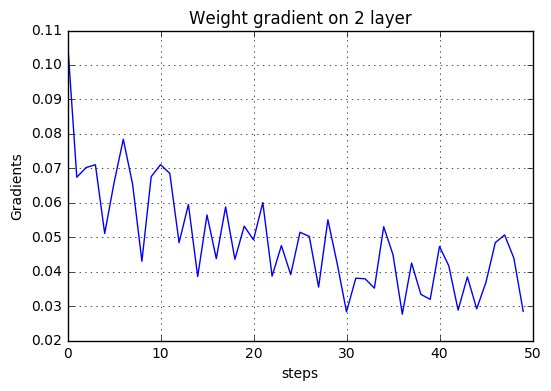

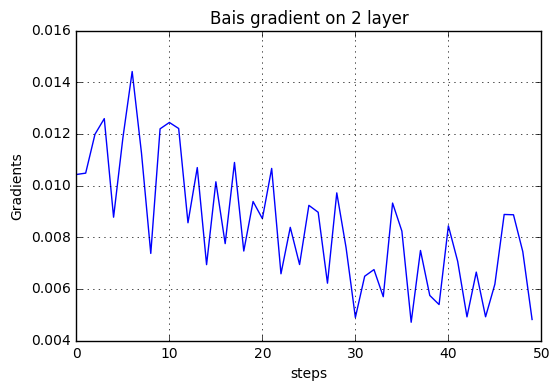

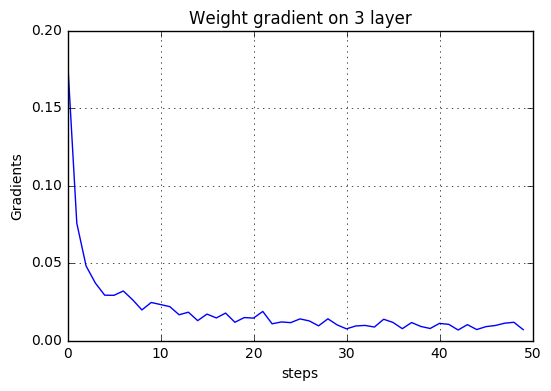

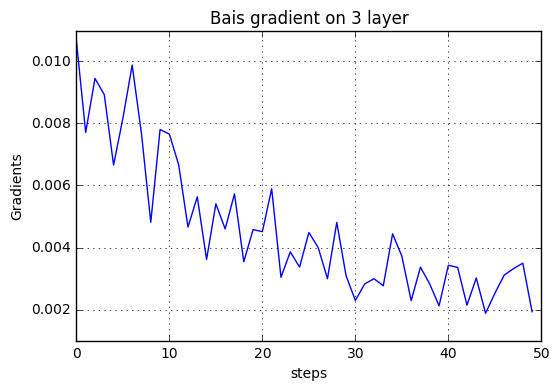

In [43]:
D_in_9 = int(x_tr.size()[1])
D_hidden1 = 100
D_hidden2 = 50
D_out_9 = 10
layer_9 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_hidden1)},
           {"name": "sigmoid", "module": nn.Sigmoid()},
           {"name":"Linear1", "module": nn.Linear(D_hidden1, D_hidden2)},
           {"name": "Tanh", "module": nn.Tanh()},
           {"name":"Linear2", "module": nn.Linear(D_hidden2, D_out_1)}]

loss_func_9 =  nn.CrossEntropyLoss(size_average=True)
layers_num_9 = 3
model_9 = NeuNet(layer_9, loss_func = loss_func_9, layers_num = layers_num_9, opt_learning_rate = 1e-4)

        
model_9.train(x_tr, y_tr)
model_9.report(x_tr, y_tr, x_tt, y_tt)

Результаты явно продолжают улучшаться!

## Четырёхслойная модель

Calculation time: 345.869997025 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      4890
          1       0.99      0.98      0.99      5557
          2       0.98      0.97      0.97      4850
          3       0.97      0.98      0.97      5043
          4       0.96      0.98      0.97      4777
          5       0.98      0.97      0.98      4342
          6       0.99      0.98      0.98      4784
          7       0.98      0.99      0.98      5087
          8       0.95      0.98      0.96      4773
          9       0.97      0.97      0.97      4897

avg / total       0.98      0.98      0.98     49000

47904 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

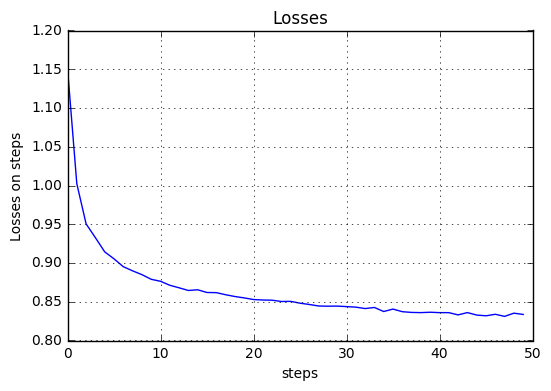

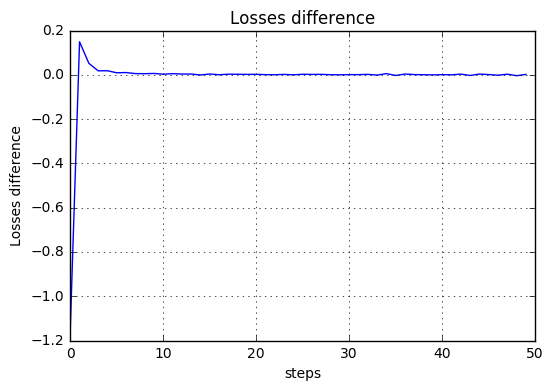

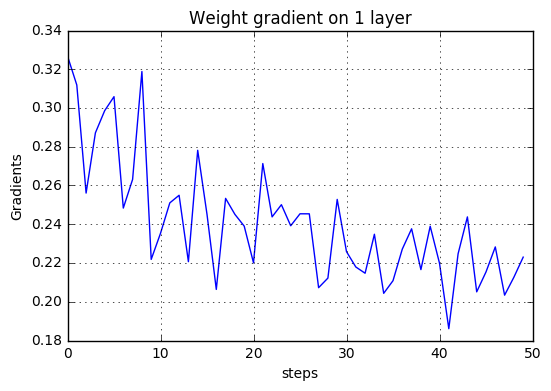

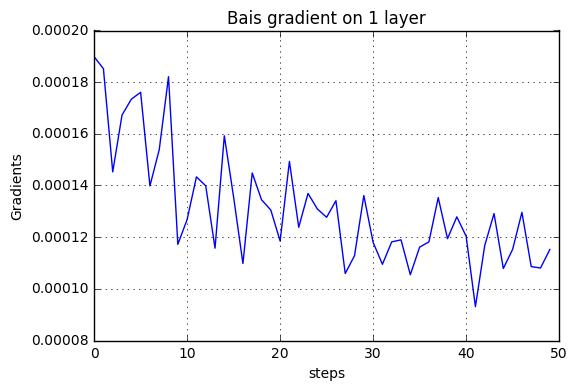

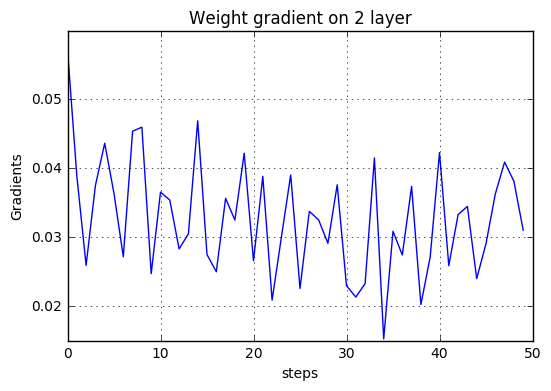

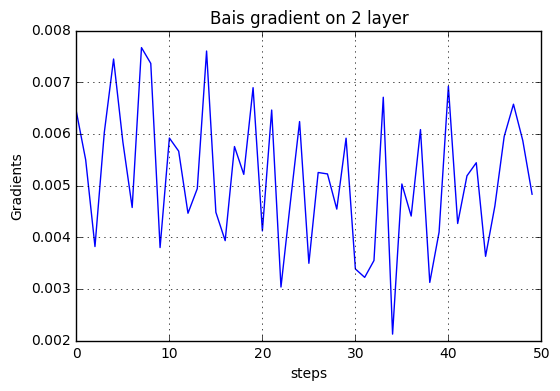

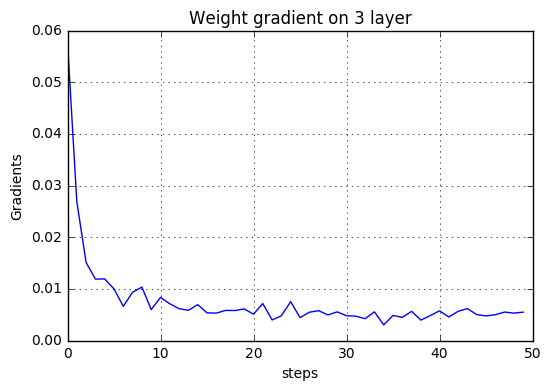

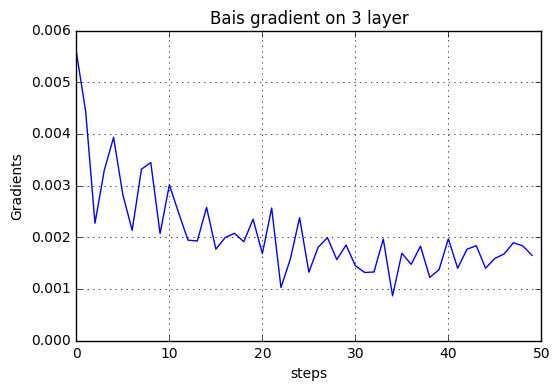

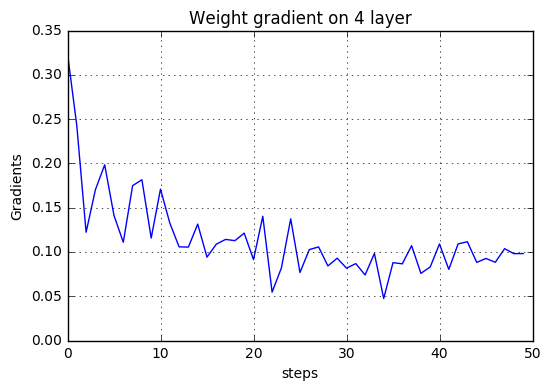

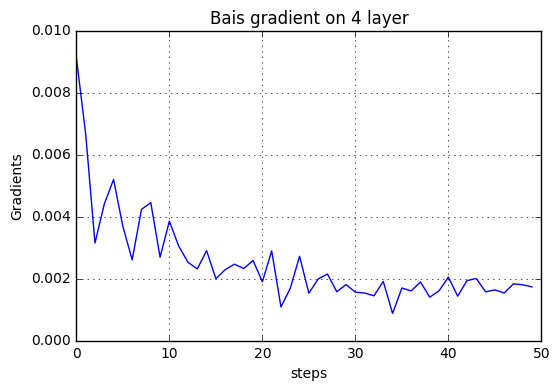

In [42]:
D_in_10 = int(x_tr.size()[1])
D_hidden1 = 100
D_hidden2 = 50
D_hidden3 = 50
D_out_10 = 10
layer_10 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_hidden1)},
           {"name": "sigmoid", "module": nn.Sigmoid()},
           {"name":"Linear1", "module": nn.Linear(D_hidden1, D_hidden2)},
           {"name": "Tanh", "module": nn.Tanh()},
           {"name":"Linear2", "module": nn.Linear(D_hidden2, D_hidden3)},
           {"name":"LSM", "module": nn.LogSoftmax()},
           {"name":"Linear3", "module": nn.Linear(D_hidden3, D_out_1)},
           {"name":"tanh2", "module": nn.Tanh()}]
        
loss_func_10 =  nn.CrossEntropyLoss(size_average=True)
layers_num_10 = 4
model_10 = NeuNet(layer_10, loss_func = loss_func_10, layers_num = layers_num_10, opt_learning_rate = 1e-4)

model_10.train(x_tr, y_tr)
model_10.report(x_tr, y_tr, x_tt, y_tt)

Очевидно, что при увеличении количества слоёв увеличивется время обучения. Так же заметно снижение качества обучения при добавлении 4 слоя. Таким образом наиболее оптимальной оказалось 3х слойная модель.

## Многослойная нейронная сеть без функций активации.

Calculation time: 122.782339096 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.95      0.98      0.97      4890
          1       0.96      0.98      0.97      5557
          2       0.94      0.91      0.92      4850
          3       0.92      0.90      0.91      5043
          4       0.94      0.94      0.94      4777
          5       0.90      0.88      0.89      4342
          6       0.95      0.97      0.96      4784
          7       0.95      0.94      0.94      5087
          8       0.89      0.88      0.89      4773
          9       0.90      0.92      0.91      4897

avg / total       0.93      0.93      0.93     49000

45671 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

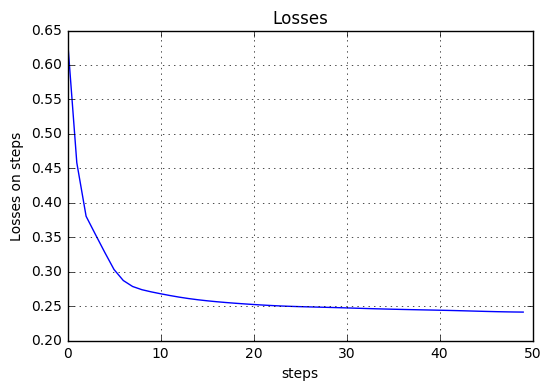

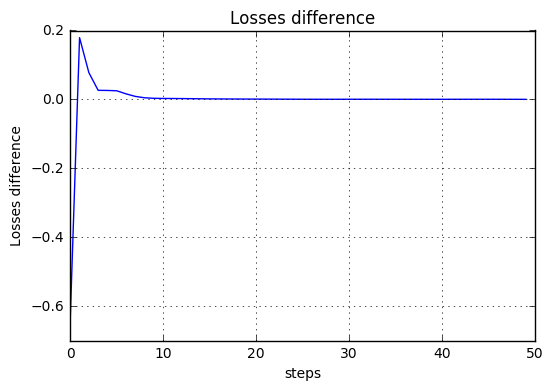

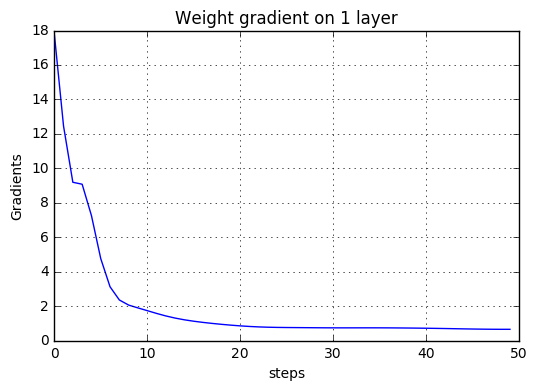

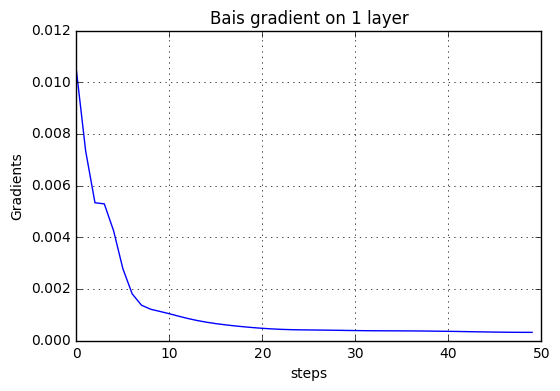

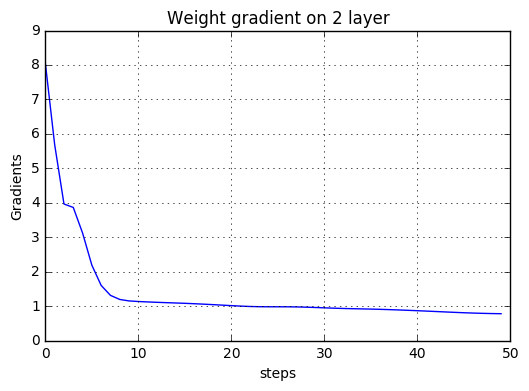

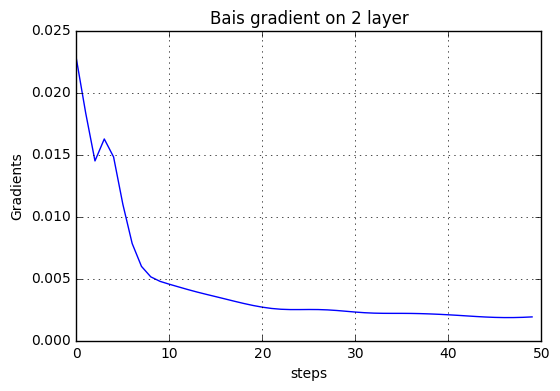

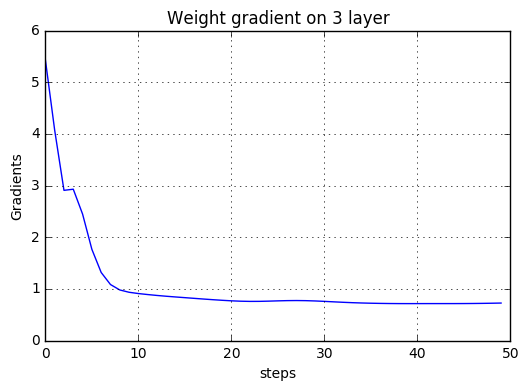

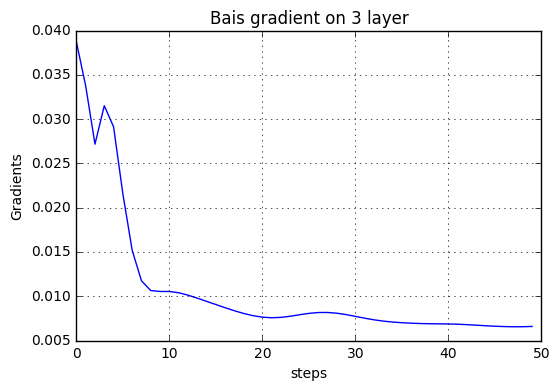

ValueError: x and y must have same first dimension

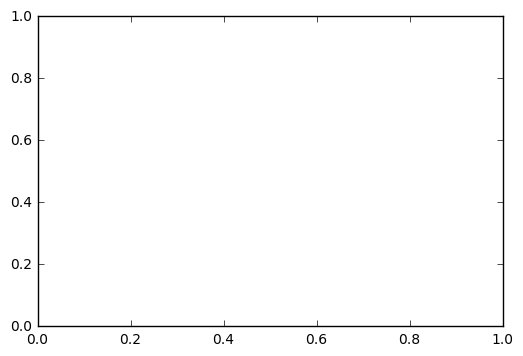

In [52]:
D_in_10 = int(x_tr.size()[1])
D_hidden1 = 100
D_hidden2 = 50
D_out_10 = 10
layer_10 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_hidden1)},
           {"name":"Linear1", "module": nn.Linear(D_hidden1, D_hidden2)},
           {"name":"Linear3", "module": nn.Linear(D_hidden2, D_out_1)}]
        
loss_func_10 =  nn.CrossEntropyLoss(size_average=True)
layers_num_10 = 4
model_10 = NeuNet(layer_10, loss_func = loss_func_10, layers_num = layers_num_10, opt_learning_rate = 1e-4)

model_10.train(x_tr, y_tr)
model_10.report(x_tr, y_tr, x_tt, y_tt)

Качество обучения данной сети не сильно превышает аналогичную однослойную. На самом деле, не сложно заметить, что, несмотря на явное отличие в количестве парамтров, подобную многослойную сеть можно привести к однослойной линейными преобразованиями.